In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
import numpy as np
sys.path.insert(0, os.path.realpath(os.path.join(os.getcwd(), '..')))
from getdist import plots, loadMCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))


#-------self biuld function----------#
from function import load_covariance_matrices

GetDist Version: 1.6.4, Matplotlib version: 3.5.3


In [3]:
samples  = loadMCSamples('./cocoa/Cocoa/projects/lsst_y1/chains/EXAMPLE_MCMC4', settings = {'ignore_rows':0.3})
#samples2 = loadMCSamples('./chain_desy3_and_kids1000_hybrid_analysis.txt', settings = {'ignore_rows':0.3})
raw_samples = samples.samples
logpost = samples.weights * samples.loglikes
max_idx = np.argmax(logpost)
best_fit_params = raw_samples[max_idx]

param_names = samples.getParamNames().names


print('The best fit point from chain:')
for name, val in zip(param_names, best_fit_params):
    print(f"{name.name}: {val}")

The best fit point from chain:
As_1e9: 2.0843481
ns: 0.98203647
H0: 62.698706
omegab: 0.033638073
omegam: 0.30329146
w: -0.97988531
LSST_DZ_S1: 0.04180968
LSST_DZ_S2: 0.0080718415
LSST_DZ_S3: 0.02637681
LSST_DZ_S4: -0.079747803
LSST_DZ_S5: -0.0011711291
LSST_A1_1: 0.54295543
LSST_A1_2: -2.2451883
LSST_M1: 0.026415125
LSST_M2: -0.051529725
LSST_M3: -0.030281587
LSST_M4: -0.021131588
LSST_M5: -0.017945674
LSST_DZ_L1: 0.008351364
LSST_DZ_L2: 0.0055820197
LSST_DZ_L3: 0.018374345
LSST_DZ_L4: -0.0034546491
LSST_DZ_L5: -0.012054153
LSST_B1_1: 1.7975855
LSST_B1_2: 1.6596597
LSST_B1_3: 1.7019445
LSST_B1_4: 1.9511023
LSST_B1_5: 2.252226
As: 2.0843481e-09
omegabh2: 0.013223556
omegach2: 0.10535905
omegal: 0.69661731
omegamh2: 0.11922775
sigma8: 0.7936117
s8h5: 1.0022562
s8omegamp5: 0.43705707
s8omegamp25: 0.58894279
age: 14.936261
rdrag: 163.394
yheused: 0.24054887
omegan: 0.0016404111
minuslogprior: -48.534438
minuslogprior__0: -48.534438
chi2: 44.058754
chi2__lsst_y1.lsst_y1_3x2pt: 44.058754


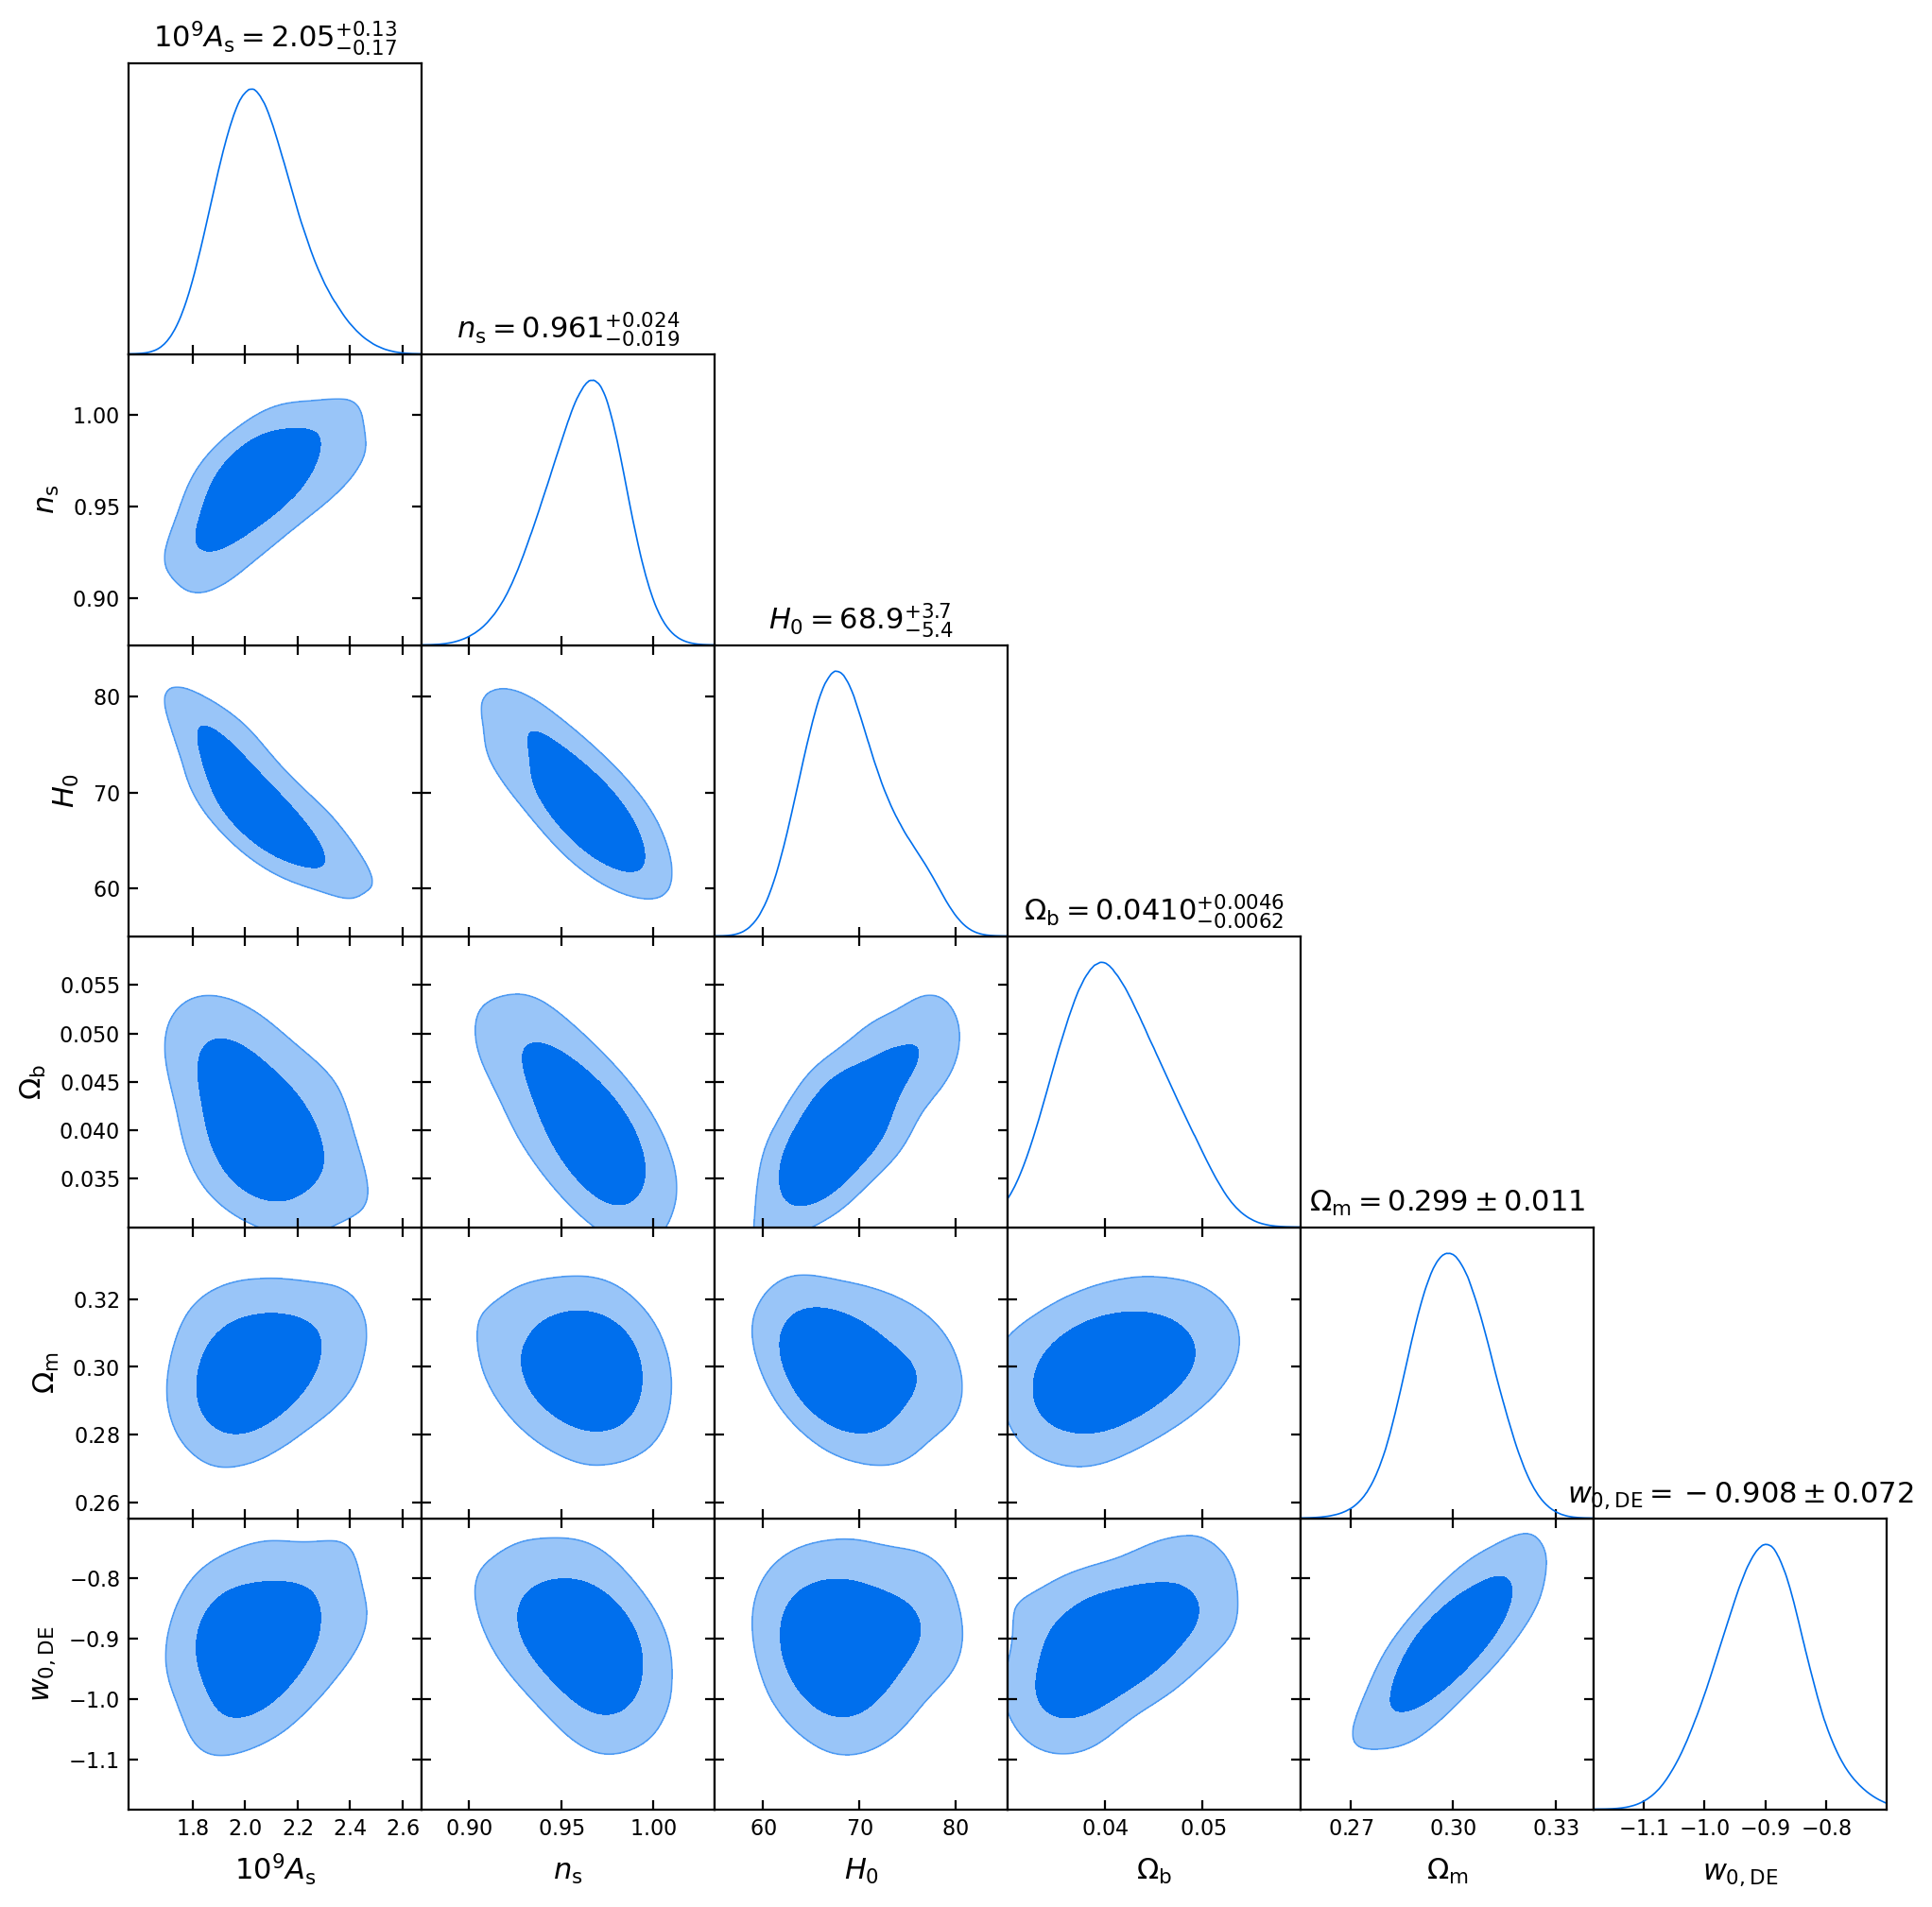

In [4]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize=14
g.triangle_plot(samples, params = [samples.getParamNames().names[i] for i in range(6)], filled=True, title_limit=1)

In [3]:
model_datavector = np.loadtxt('./cocoa/Cocoa/projects/lsst_y1/chains/lsst_y1_theory_EXAMPLE_MCMC4.modelvector')[:,1]
unmasked_model_datavector = np.loadtxt('./cocoa/Cocoa/projects/lsst_y1/chains/lsst_y1_theory_EXAMPLE_MCMC4_unmasked.modelvector')[:,1]
obs_datavector = np.loadtxt('./cocoa/Cocoa/projects/lsst_y1/data/lsst_y1_theory.modelvector')[:,1]
C_1, C_2 = load_covariance_matrices('./cocoa/Cocoa/projects/lsst_y1/data/lsst_y1_cov')

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations_with_replacement, product
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_observable(observable_name,
                    flat_data,
                    obs_flat_data,
                    cov_data,
                    shape,
                    ntomo=5,
                    n_theta=26,
                    theta_min=2.5,
                    theta_max=900.0,
                    savefile=None):
    """
    Simplified plotting function (always expects obs_flat_data and cov_data).
    
    Parameters:
    - observable_name: Name of the observable (string).
    - flat_data      : 1D array of model values, length = n_pairs * n_theta.
    - obs_flat_data  : 1D array of observational values, same length as flat_data.
    - cov_data       : 2D covariance matrix of shape (len(flat_data), len(flat_data)).
    - shape          : "triangle", "square", or "strip".
    - ntomo          : Number of tomographic bins.
    - n_theta        : Number of θ points per bin/pair.
    - theta_min, theta_max: Range for θ in arcminutes.
    - savefile       : If provided, save the figure to this filename.
    """
    Tex = {"xi+": r"\xi+",
           "xi-": r"\xi-",
           "gxgamma": r"\gamma t",
           "gxg": r"{W(\theta)}"}

    # 1. Build bin‐pair list and figure dimensions
    if shape == "triangle":
        zbin_pairs = list(combinations_with_replacement(range(ntomo), 2))
        n_pairs = len(zbin_pairs)  # ntomo*(ntomo+1)//2
        nrows, ncols = ntomo, ntomo
    elif shape == "square":
        zbin_pairs = list(product(range(ntomo), range(ntomo)))
        n_pairs = len(zbin_pairs)  # ntomo*ntomo
        nrows, ncols = ntomo, ntomo
    elif shape == "strip":
        zbin_pairs = [(i,) for i in range(ntomo)]
        n_pairs = len(zbin_pairs)  # ntomo
        nrows, ncols = 1, ntomo
    else:
        raise ValueError(f"Unknown shape='{shape}'. Must be one of 'triangle','square','strip'.")

    # 2. Generate theta grid
    theta = np.logspace(np.log10(theta_min), np.log10(theta_max), n_theta)

    # 3. Create Figure and Axes
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(4 * ncols, 4 * nrows),
                             sharex=True, sharey=True,
                             constrained_layout=True)
    fig.subplots_adjust(bottom=0.05)  # ensure inset doesn’t overlap main axes

    if nrows == 1:
        axes = axes[np.newaxis, :]  # shape becomes (1, ncols)

    fig.suptitle(f"{observable_name} vs θ  ({shape} layout)", fontsize=16)
    fig.subplots_adjust(top=0.92)

    # 4. Loop over each bin pair or index
    for idx, pair in enumerate(zbin_pairs):
        start = idx * n_theta
        end = (idx + 1) * n_theta
        y_model = flat_data[start:end]
        y_obs = obs_flat_data[start:end]
        cov_segment = cov_data[start:end, start:end]
        err = np.sqrt(np.diag(cov_segment))

        if shape == "triangle":
            i, j = pair
            if i > j:
                axes[j, i].axis("off")
                continue
            ax = axes[j, i]
        elif shape == "square":
            i, j = pair
            ax = axes[j, i]
        else:  # shape == "strip"
            i = pair[0]
            ax = axes[0, i]

        # 4.1 Plot model
        ax.plot(theta, y_obs, '-k', label='obs')

        # 4.2 Plot obs with errorbars
        ax.errorbar(theta, y_model, yerr=err,
                    fmt='o', label='model',
                    capsize=2, markersize=4, elinewidth=0.8)

        # 4.3 Legend
        ax.legend(loc='best', fontsize=6, frameon=False)

        # 4.4 Axis scaling and formatting
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.yaxis.set_major_formatter(
            ticker.LogFormatterSciNotation(base=10, labelOnlyBase=False)
        )
        ax.grid(True, which='both', ls='--', lw=0.3)

        # 4.5 Labels and annotation
        if shape in ("triangle", "square"):
            if i == 0:
                ax.set_ylabel(fr"${Tex[observable_name]}$")
            if j < ntomo - 1:
                ax.set_xticklabels([])
            ax.text(0.05, 0.95, f"({i},{j})", transform=ax.transAxes,
                    ha='left', va='top', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.6))
            if j == ntomo - 1:
                ax.set_xlabel(r"$\theta$ [arcmin]")
        else:  # strip
            if i == 0:
                ax.set_ylabel(fr"${Tex[observable_name]}$")
            ax.text(0.05, 0.95, f"({i})", transform=ax.transAxes,
                    ha='left', va='top', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.6))
            ax.set_xlabel(r"$\theta$ [arcmin]")

        # 4.6 Residual inset with errorbars (resid = model - obs)
        resid = y_model - y_obs
        ax_res = inset_axes(ax,
                            width="100%", height="15%",
                            loc='lower center',
                            bbox_to_anchor=(0, -0.17, 1, 1),
                            bbox_transform=ax.transAxes)
        ax_res.axhline(y=0, color='k', linestyle='-')
        ax_res.errorbar(theta, resid, yerr=err,
                        fmt='.', capsize=2, markersize=3, elinewidth=0.6)
        ax_res.set_xscale("log")
        ax_res.yaxis.set_major_formatter(
            ticker.LogFormatterSciNotation(base=10, labelOnlyBase=False)
        )
        if i == 0:
            ax_res.set_ylabel(
                fr"$\Delta {Tex[observable_name]}/\sigma_{{{Tex[observable_name]}}}$",
                fontsize=10
            )
        ax_res.tick_params(axis='y', labelsize=6)
        if shape in ("triangle", "square") and j < ntomo - 1:
            ax_res.set_xticklabels([])

    # 5. Hide lower‐triangle for "triangle"
    if shape == "triangle":
        for ii in range(ntomo):
            for jj in range(ntomo):
                if ii > jj:
                    axes[jj, ii].axis("off")

    # 6. Save or show
    if savefile:
        fig.savefig(savefile, dpi=150)
        plt.close(fig)
    else:
        plt.show()


def plot_all_observables(datavector,
                         obs_datavector,
                         C_1,
                         C_2,
                         ntomo=5,
                         n_theta=26,
                         theta_min=2.5,
                         theta_max=900.0,
                         save=False):
    """
    Simplified main function (always expects obs_datavector, C_1, C_2).
    
    Splits the length-1560 datavector into four segments and plots each:
      - xi+     : length = 15*26 → shape="triangle"
      - xi-     : length = 15*26 → shape="triangle"
      - gxgamma : length = 25*26 → shape="square"
      - gxg     : length = 5*26  → shape="strip"
    """
    # Compute segment lengths
    n_pairs_triangle = ntomo * (ntomo + 1) // 2  # 15 for ntomo=5
    len_triangle = n_pairs_triangle * n_theta     # 15*26 = 390
    n_pairs_square = ntomo * ntomo                # 25
    len_square = n_pairs_square * n_theta         # 25*26 = 650
    n_pairs_strip = ntomo                         # 5
    len_strip = n_pairs_strip * n_theta           # 5*26 = 130

    len_each = [len_triangle, len_triangle, len_square, len_strip]
    shapes = ["triangle", "triangle", "square", "strip"]
    names  = ["xi+",      "xi-",      "gxgamma",    "gxg"]

    start = 0
    for idx, obs_name in enumerate(names):
        seg_len = len_each[idx]
        flat_data = datavector[start : start + seg_len]
        obs_flat = obs_datavector[start : start + seg_len]
        cov_seg = (
            C_1[start : start + seg_len, start : start + seg_len]
            + C_2[start : start + seg_len, start : start + seg_len]
        )

        if save:
            if shapes[idx] == "triangle":
                filename = f"{obs_name}_triangle.png"
            elif shapes[idx] == "square":
                filename = f"{obs_name}_square.png"
            else:  # "strip"
                filename = f"{obs_name}_strip.png"
        else:
            filename = None

        plot_observable(
            observable_name=obs_name,
            flat_data=flat_data,
            obs_flat_data=obs_flat,
            cov_data=cov_seg,
            shape=shapes[idx],
            ntomo=ntomo,
            n_theta=n_theta,
            theta_min=theta_min,
            theta_max=theta_max,
            savefile=filename
        )
        start += seg_len


/home/junzhou/ipykernel_1505716/2693962822.py:60: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(bottom=0.05)  # ensure inset doesn’t overlap main axes


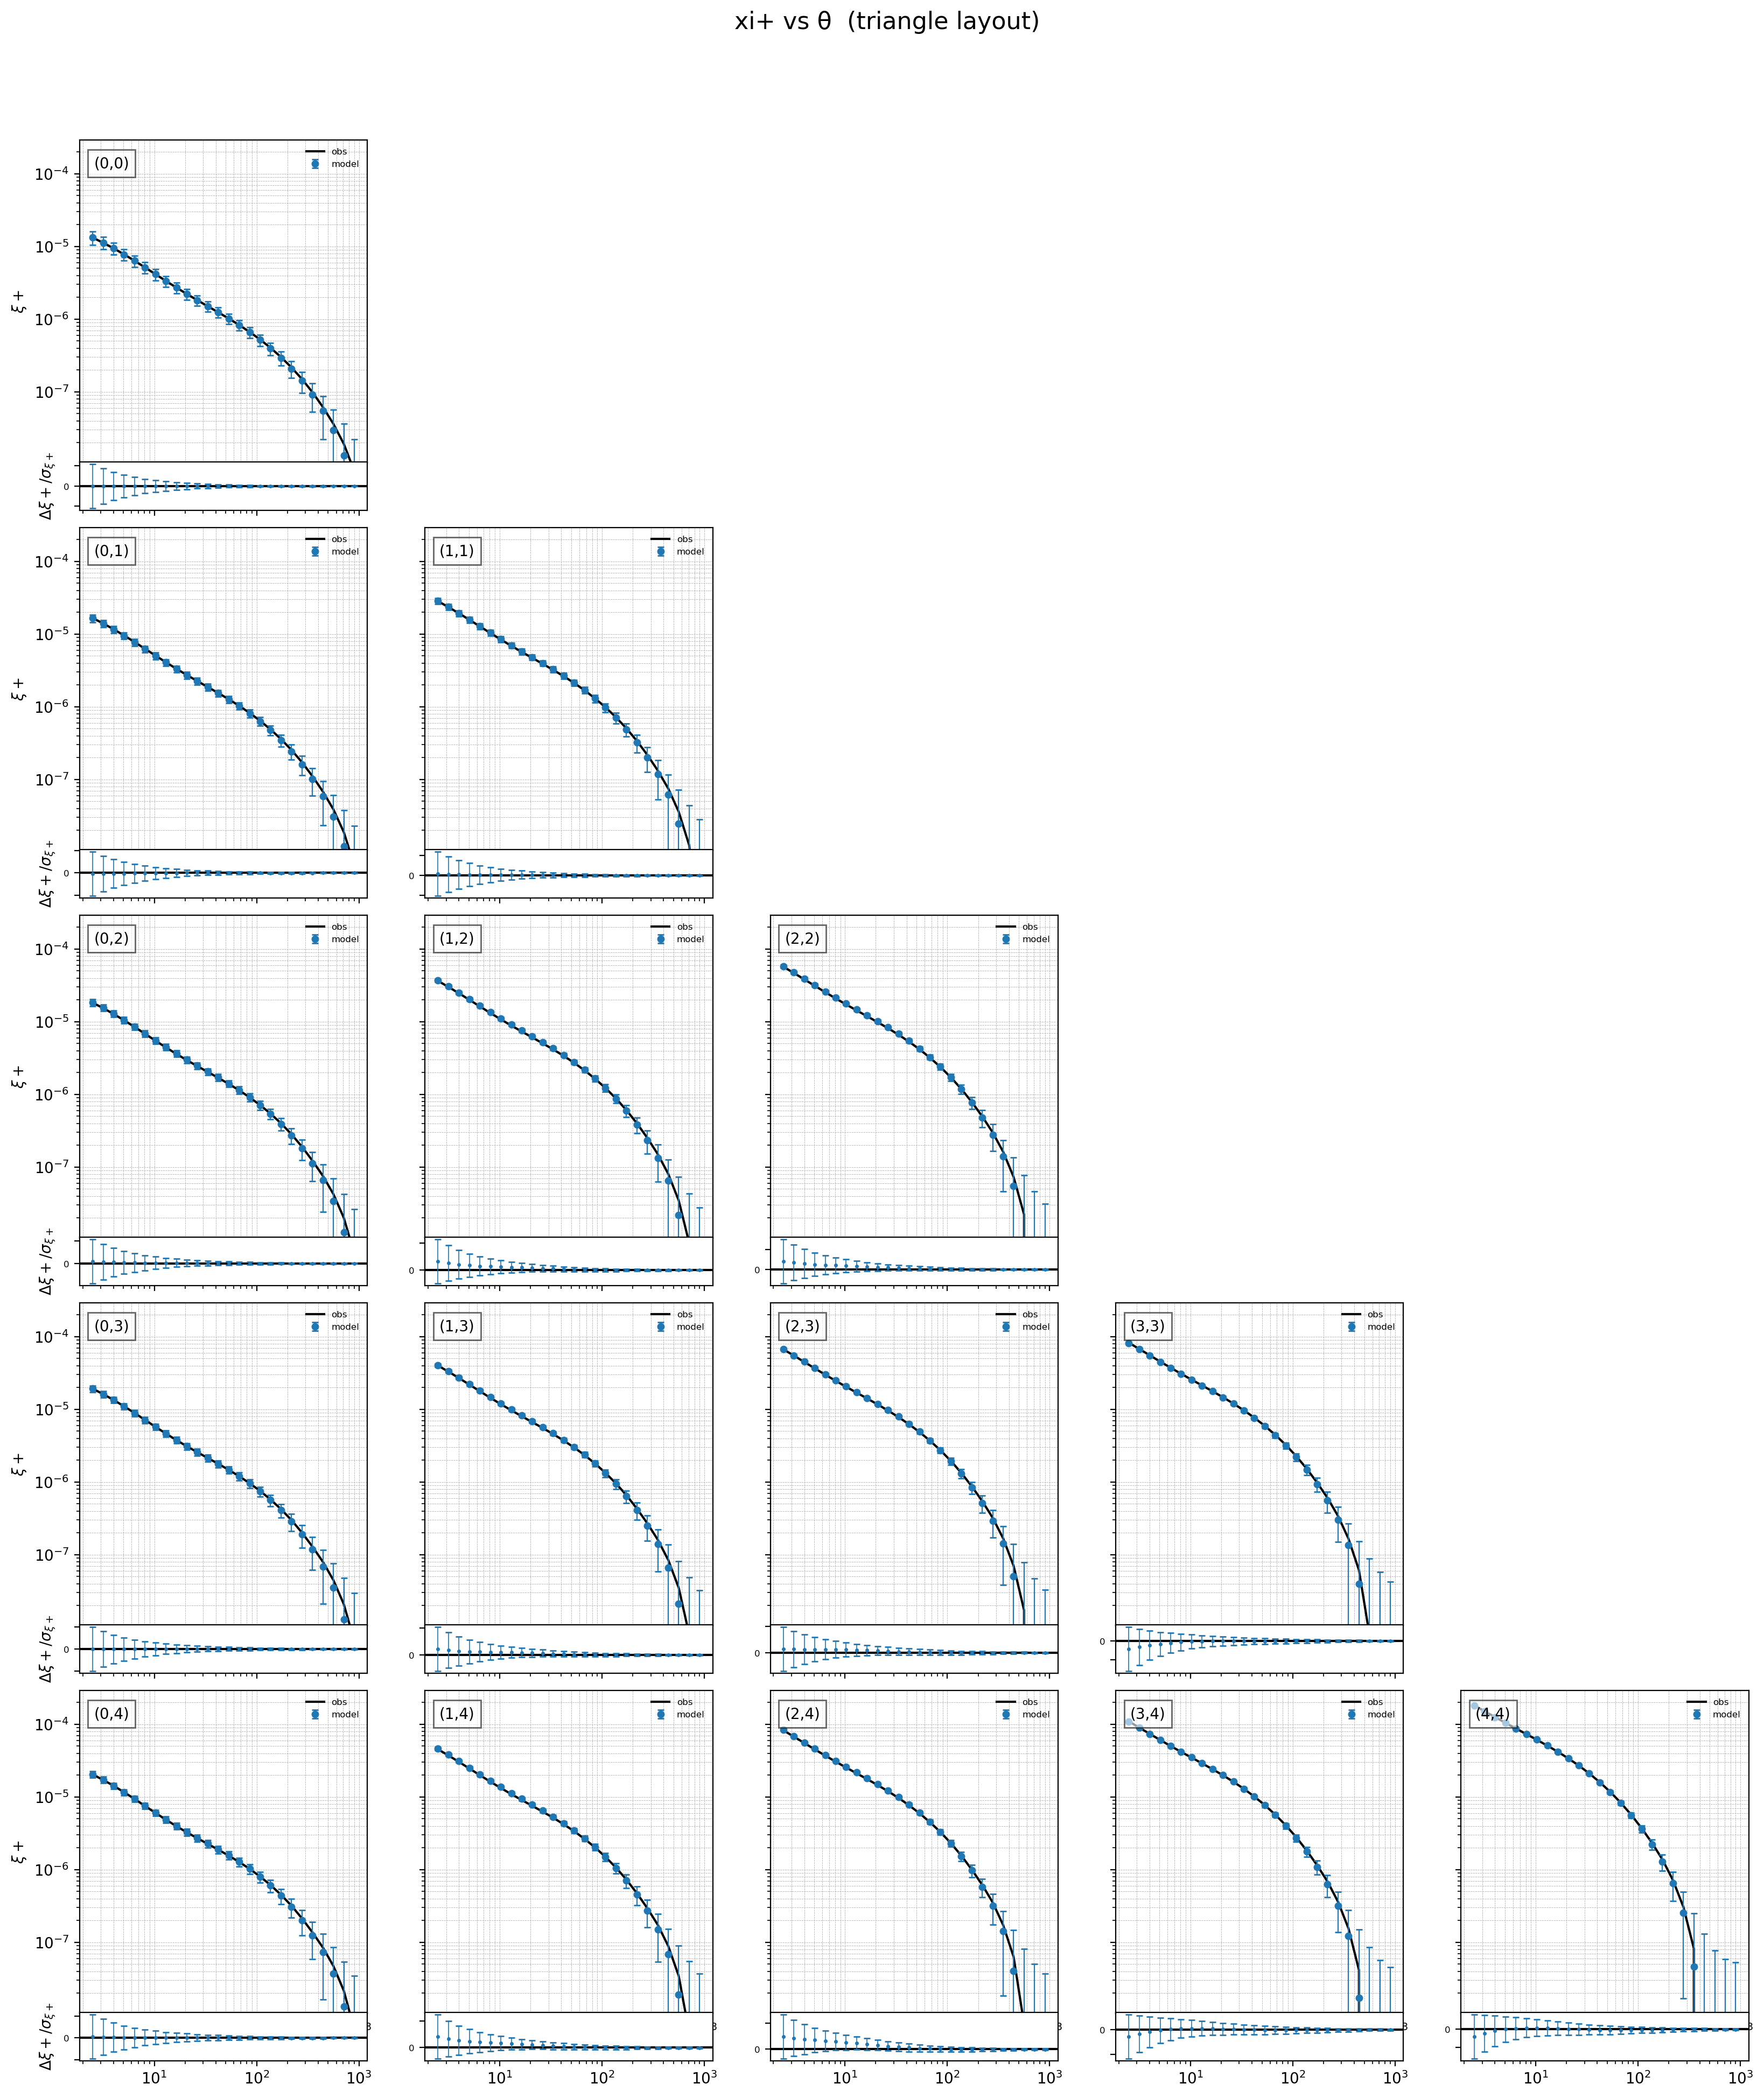

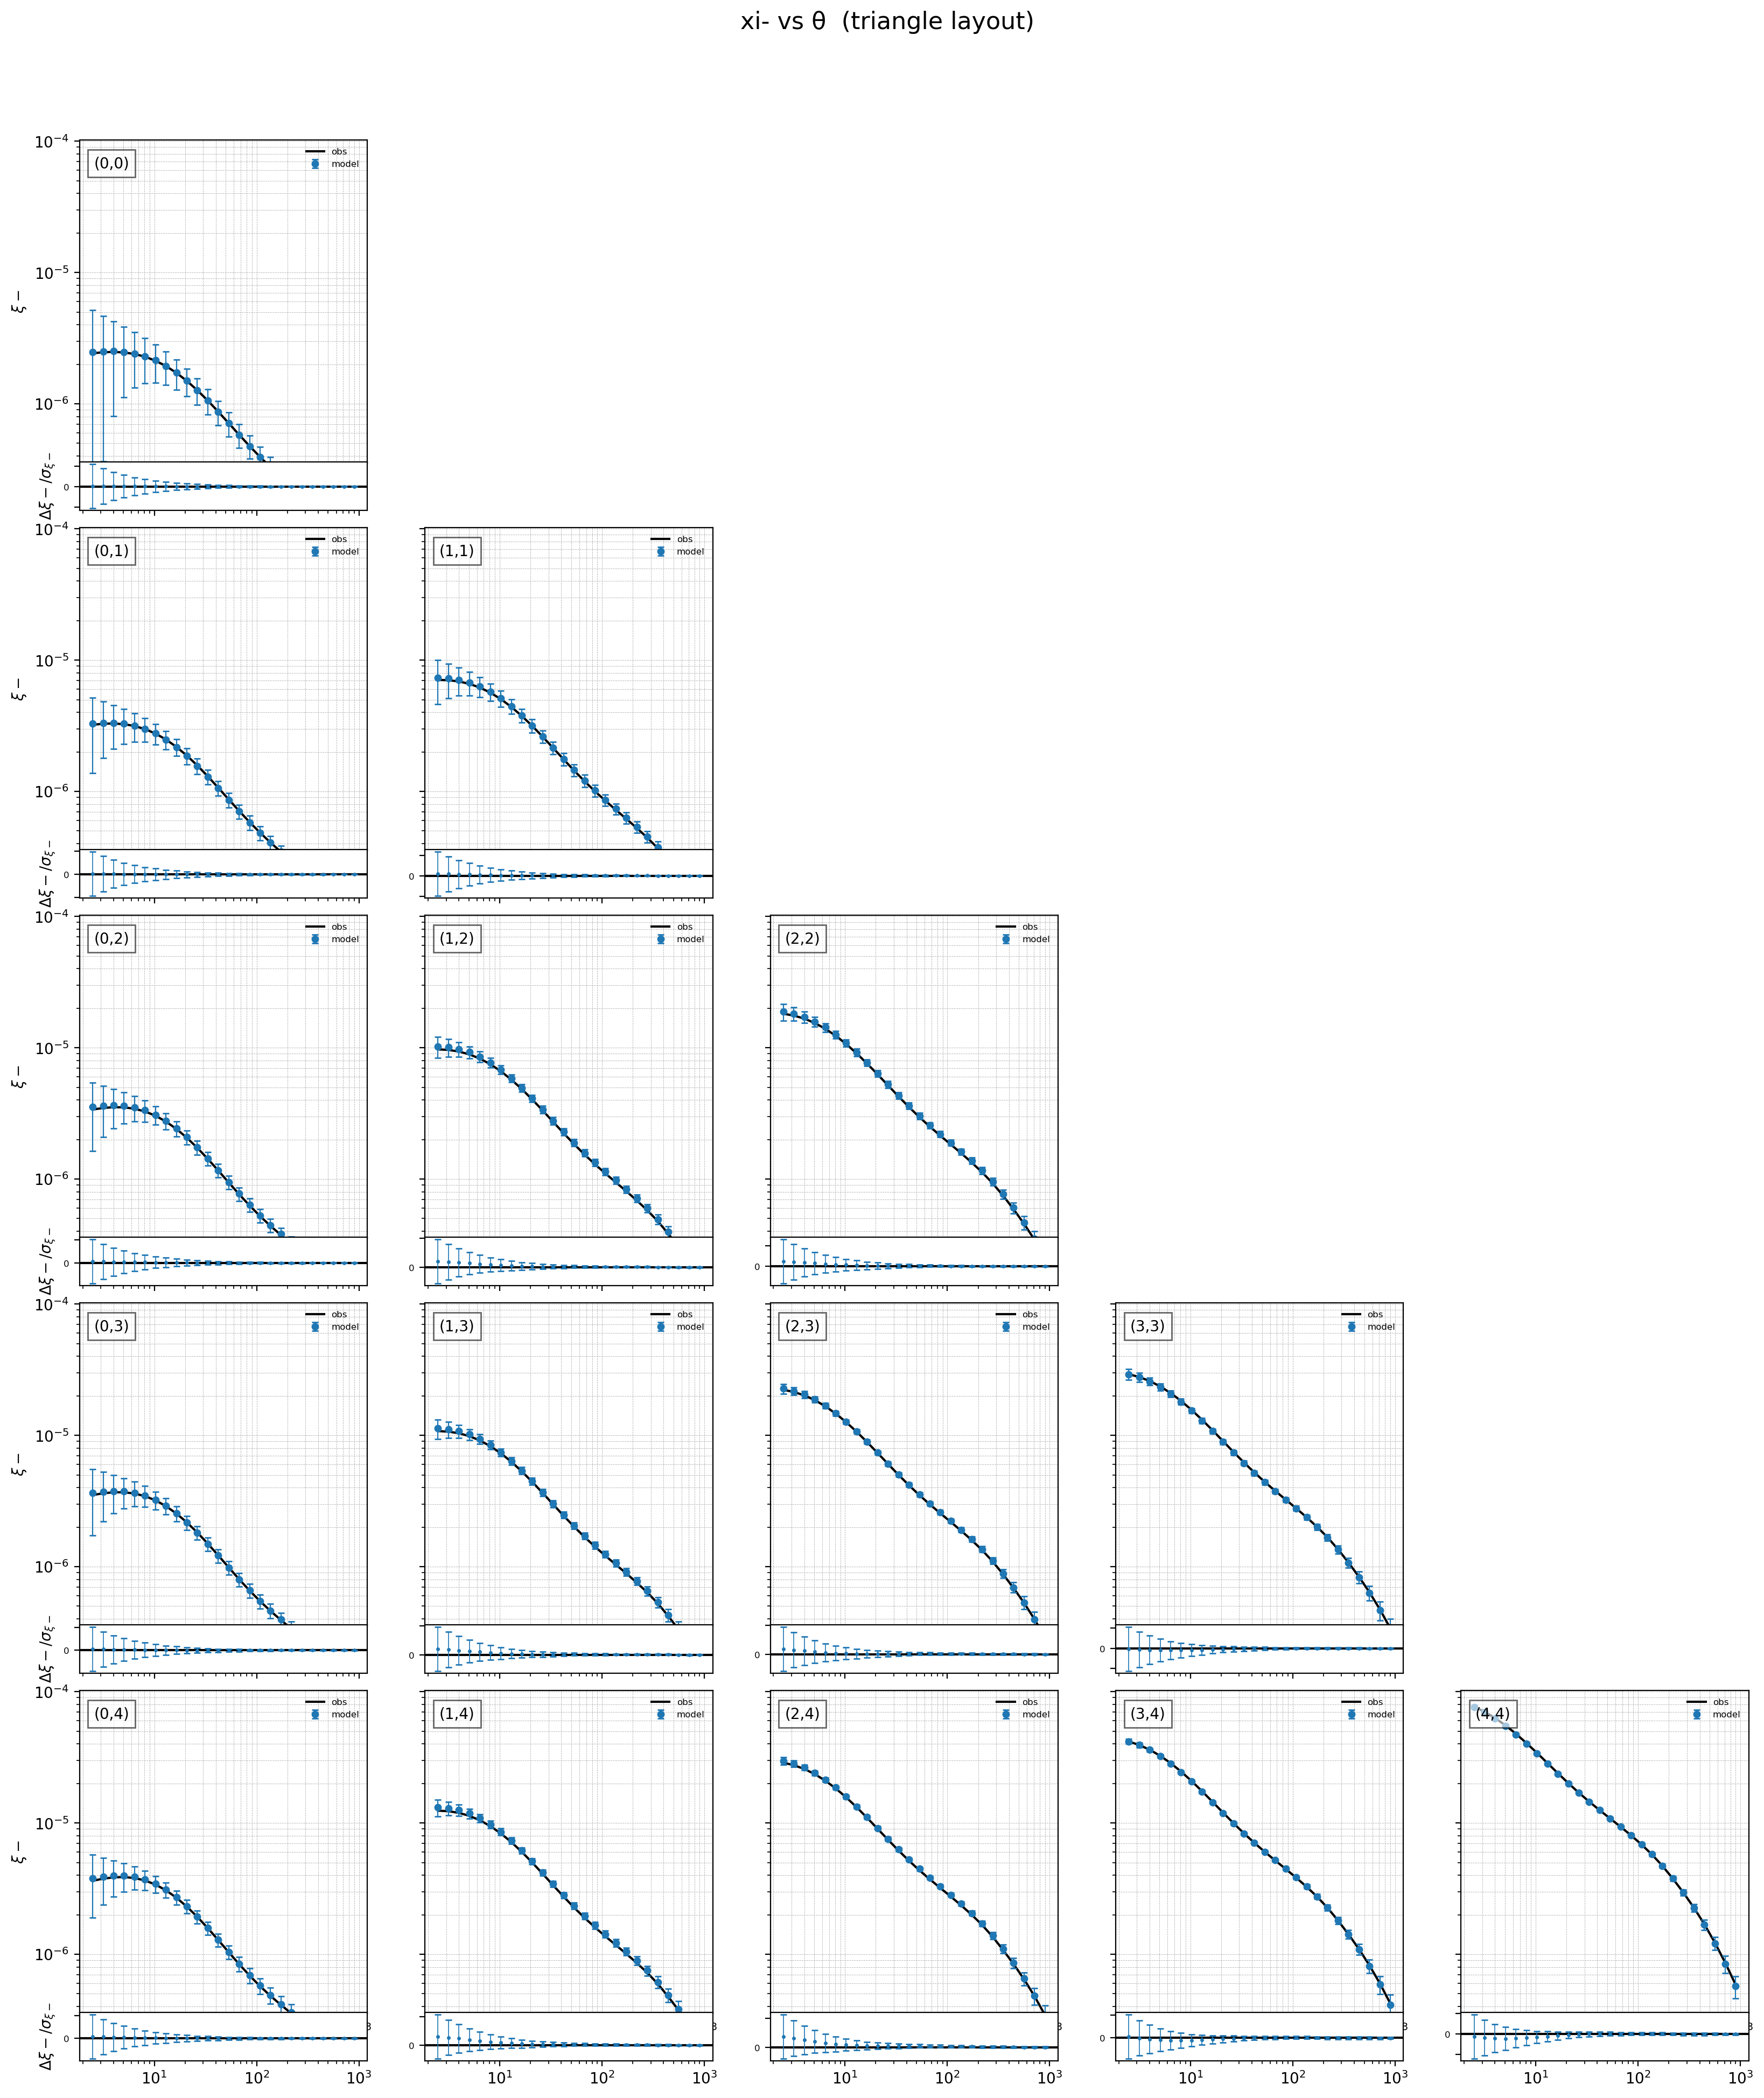

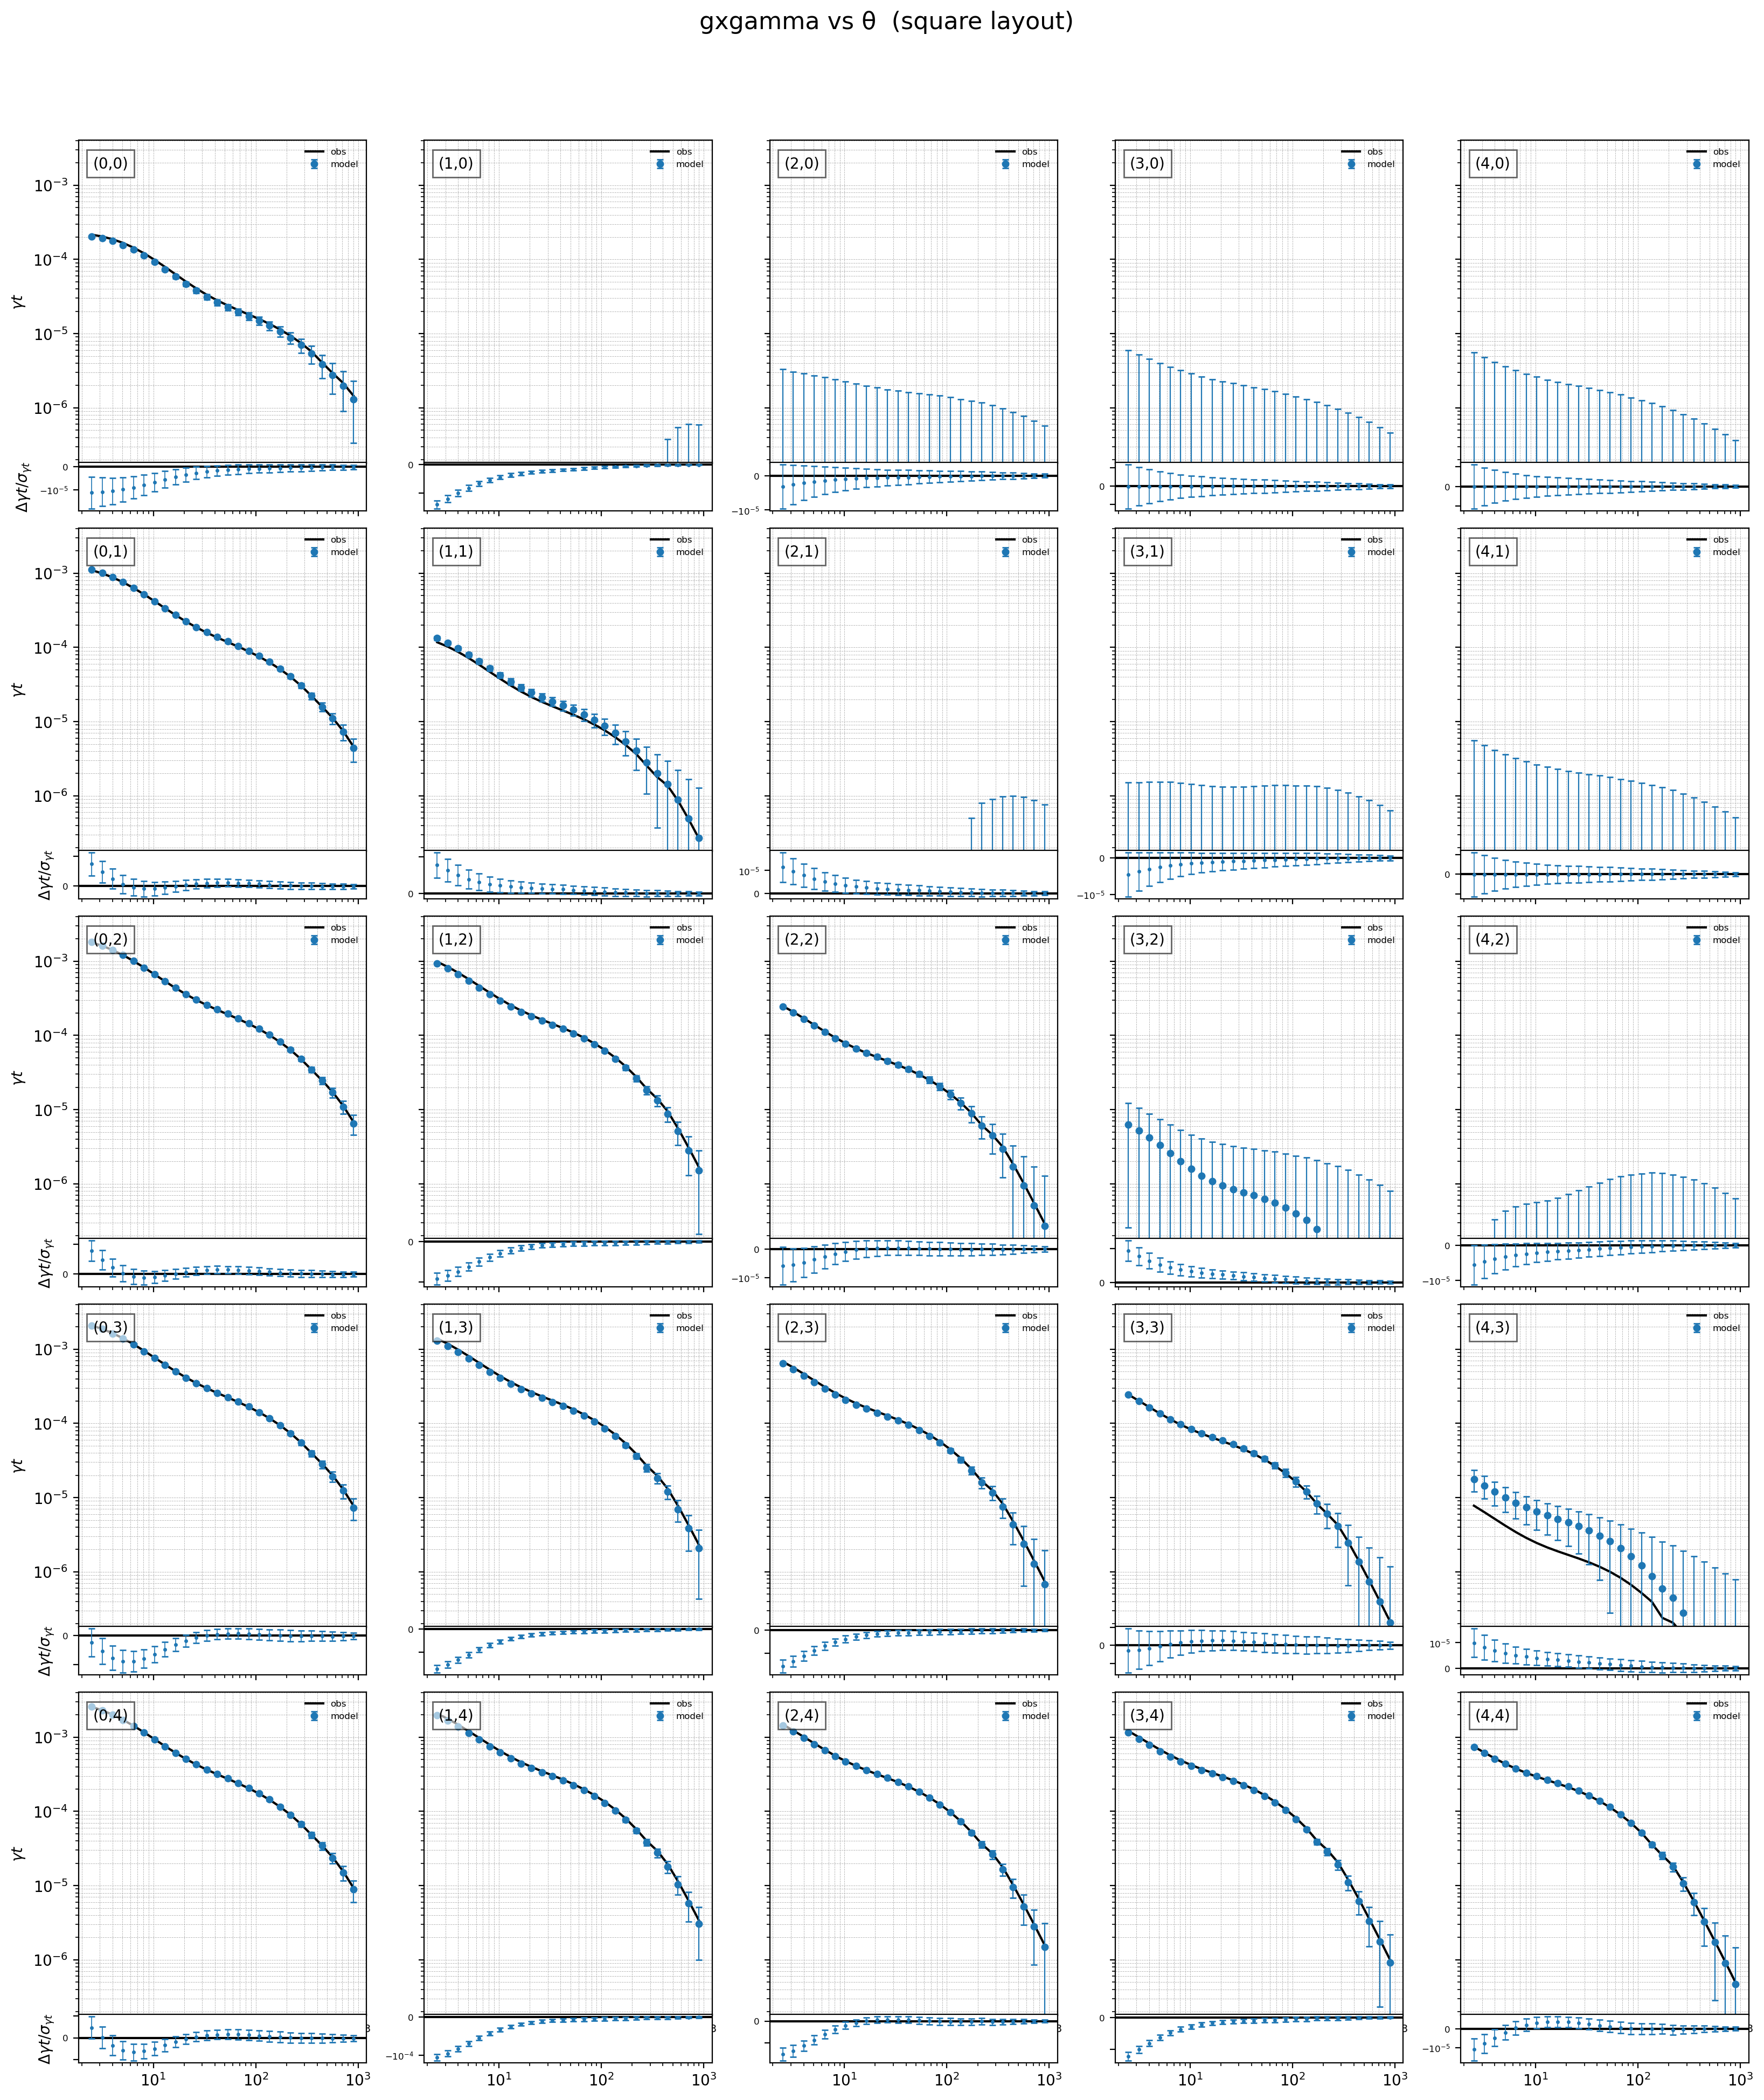

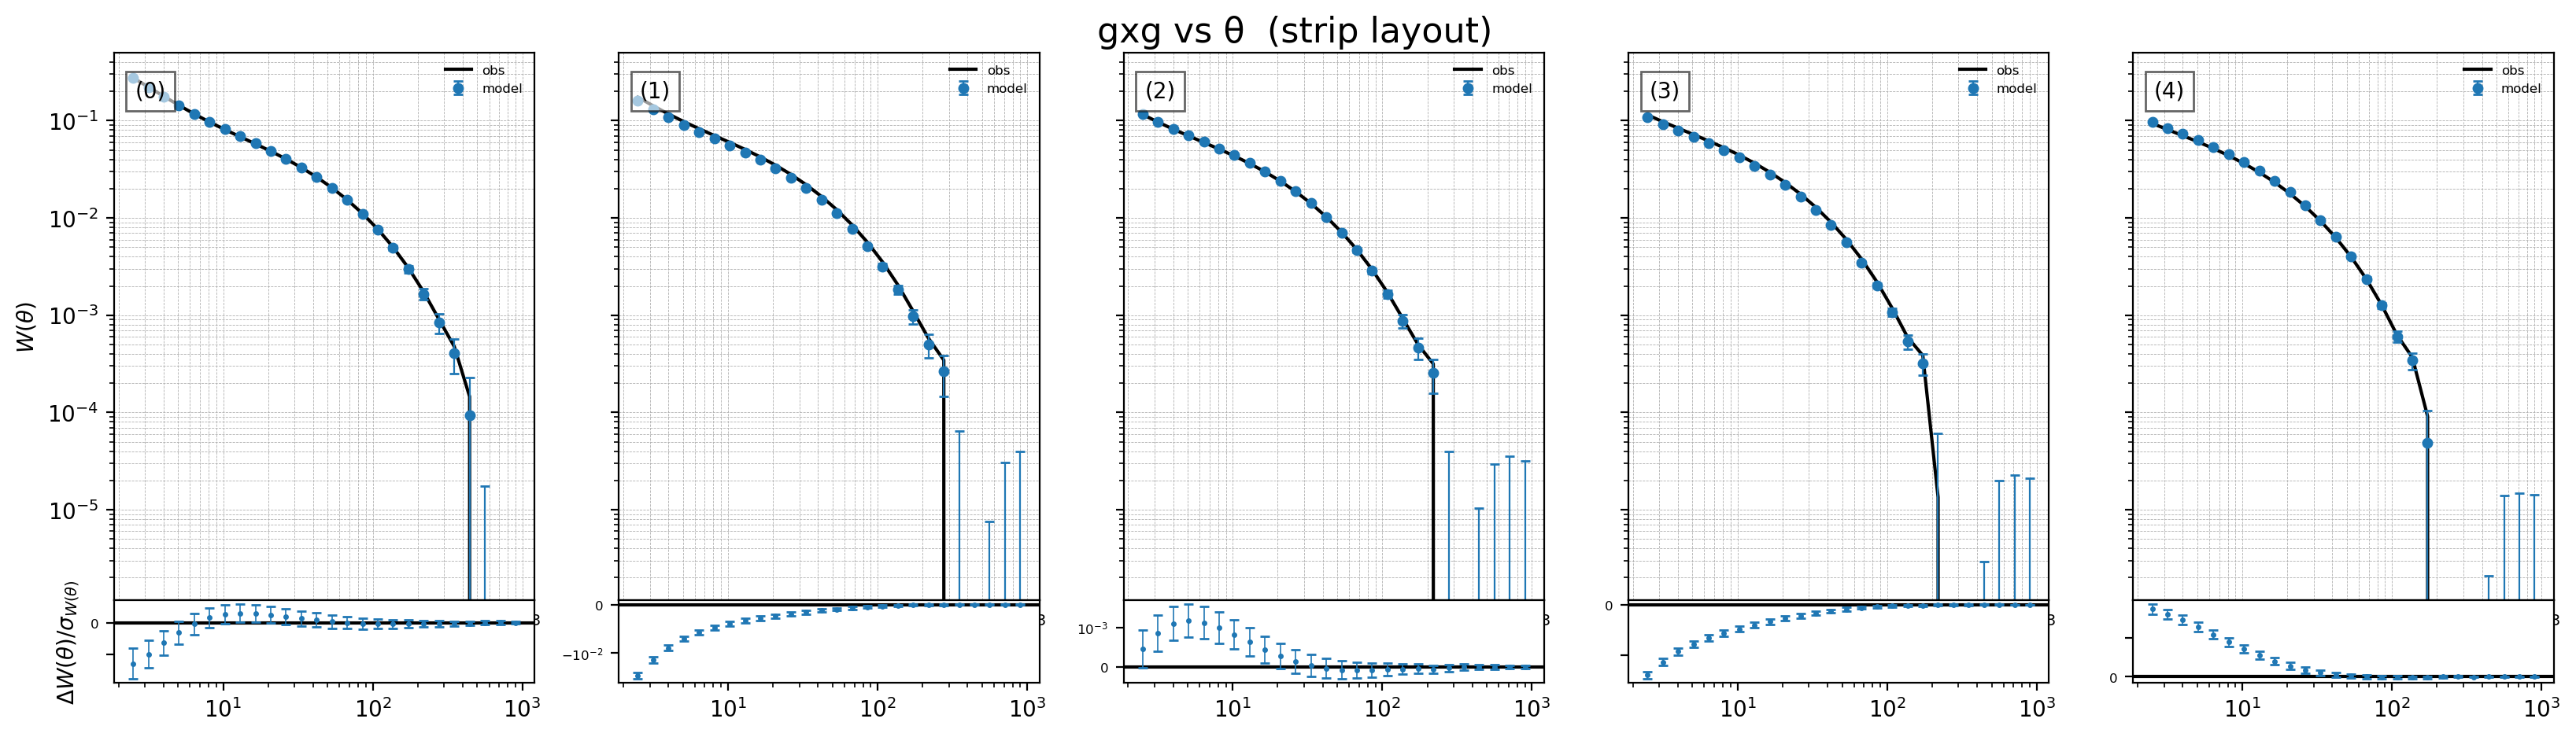

In [74]:
plot_all_observables(unmasked_model_datavector, obs_datavector, C_1, C_2)